In [2]:

%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score




from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pylab as plt

no display found. Using non-interactive Agg backend


In [96]:
#PCA analysis
PCA_df = pd.read_csv('D:/Course/big data II/project/PCA.csv')
pcs = PCA()
pcs.fit(PCA_df.iloc[:, 2:].dropna(axis=0))
pcsSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                           'Proportion of variance': pcs.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary_df = pcsSummary_df.transpose()
pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)]
pcsSummary_df.round(4)

PC1           PC2          PC3          PC4  \
Standard deviation      7.197149e+06  3.140257e+06  215144.5952  137995.8743   
Proportion of variance  8.391000e-01  1.597000e-01       0.0007       0.0003   
Cumulative proportion   8.391000e-01  9.988000e-01       0.9995       0.9998   

                               PC5        PC6        PC7       PC8     PC9  
Standard deviation      97786.3017  4259.6019  1451.8665  111.7623  1.0718  
Proportion of variance      0.0002     0.0000     0.0000    0.0000  0.0000  
Cumulative proportion       1.0000     1.0000     1.0000    1.0000  1.0000

In [97]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(), columns=pcsSummary_df.columns, 
                                index=PCA_df.iloc[:, 2:].columns)
pcsComponents_df.iloc[:,:5]

PC1           PC2       PC3       PC4  \
existing_confirmed_TP    1.139742e-03 -3.215995e-04 -0.009123  0.001597   
15-64                    7.747423e-02  9.774056e-01  0.048208  0.189345   
65-                      1.218049e-02  1.935520e-01 -0.385037 -0.901433   
pop_density             -6.667170e-05 -1.616443e-04 -0.003173 -0.004092   
total_passenger_volume   1.197843e-02  2.457462e-02  0.893539 -0.386107   
actual_passenger_volume  9.968289e-01 -7.874779e-02 -0.011138  0.001238   
avg_age                  3.774572e-08  1.383390e-07  0.000001 -0.000009   
hospitals                8.106497e-06  1.651456e-05  0.000366 -0.000059   
hospital_beds            6.057587e-03  2.026532e-02  0.225373 -0.049676   

                              PC5  
existing_confirmed_TP    0.004957  
15-64                    0.022358  
65-                     -0.039133  
pop_density              0.011185  
total_passenger_volume   0.227381  
actual_passenger_volume  0.001914  
avg_age                  0.000004  
hospitals               -0.001242  
hospital_beds           -0.972683

In [111]:
air_df = pd.read_csv('D:/Course/big data II/PCA.csv')

In [113]:
predictors = ['PC1','PC2','PC3','PC4','PC5']
outcome = 'existing_confirmed_TP'

# partition data
X = pd.get_dummies(air_df[predictors], drop_first=True)
y = air_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.03, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))
regressionSummary(train_y, car_lm.predict(train_X))

intercept  -663.5150800613919
  Predictor  coefficient
0       PC1    -0.012033
1       PC2    -0.171455
2       PC3     0.164108
3       PC4     0.021233
4       PC5     0.244672

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 8595.5072
     Mean Absolute Error (MAE) : 3066.7859

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 8595.5072
     Mean Absolute Error (MAE) : 3066.7859


In [114]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  -0.14803570397363108
AIC :  684.5877418233854
BIC :  694.8478931429835


In [115]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

      Predicted  Actual     Residual
14  4824.298087     416 -4408.298087
19   152.367178     193    40.632822

Regression statistics

                      Mean Error (ME) : -2183.8326
       Root Mean Squared Error (RMSE) : 3117.2699
            Mean Absolute Error (MAE) : 2224.4655
          Mean Percentage Error (MPE) : -519.3169
Mean Absolute Percentage Error (MAPE) : 540.3702


0.5


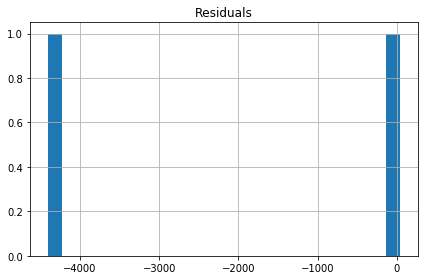

In [116]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [117]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')


   n     r2adj         AIC    PC1    PC2    PC3    PC4    PC5
0  1 -0.026464  677.585114  False  False  False   True  False
1  2 -0.056590  679.425927  False   True  False   True  False
2  3 -0.082456  681.076969  False   True   True  False   True
3  4 -0.113738  682.824857  False   True   True   True   True
4  5 -0.148036  684.587742   True   True   True   True   True


In [118]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: PC1, PC2, PC3, PC4, PC5
Start: score=684.59
Step: score=682.82, remove PC1
Step: score=681.08, remove PC4
Step: score=679.69, remove PC5
Step: score=677.70, remove PC3
['PC2']


In [119]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : -1799.6670
       Root Mean Squared Error (RMSE) : 1802.6362
            Mean Absolute Error (MAE) : 1799.6670
          Mean Percentage Error (MPE) : -668.1785
Mean Absolute Percentage Error (MAPE) : 668.1785


In [130]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: PC1, PC2, PC3, PC4, PC5
Start: score=675.80, constant
Step: score=675.80, add None
[]


In [121]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: PC1, PC2, PC3, PC4, PC5
Start: score=675.80, constant
Step: score=675.80, unchanged None
[]


In [122]:
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print(lasso_cv.coef_)

ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)linearRegression = LinearRegression(normalize=True).fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))

SyntaxError: invalid syntax (<ipython-input-122-2745b16746eb>, line 18)

In [123]:
linearRegression = LinearRegression(normalize=True).fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -2183.8326
       Root Mean Squared Error (RMSE) : 3117.2699
            Mean Absolute Error (MAE) : 2224.4655
          Mean Percentage Error (MPE) : -519.3169
Mean Absolute Percentage Error (MAPE) : 540.3702


In [124]:
pd.DataFrame({'features': train_X.columns, 'linear regression': linearRegression.coef_, 
              'lassoCV': lasso_cv.coef_, 'bayesianRidge': bayesianRidge.coef_})

NameError: name 'lasso_cv' is not defined

In [127]:
# run a linear regression of existing_confirmed_TP on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'existing_confirmed_TP ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                              OLS Regression Results                             
Dep. Variable:     existing_confirmed_TP   R-squared:                       0.037
Model:                               OLS   Adj. R-squared:                 -0.148
Method:                    Least Squares   F-statistic:                    0.2005
Date:                   Tue, 05 May 2020   Prob (F-statistic):              0.959
Time:                           21:07:32   Log-Likelihood:                -335.29
No. Observations:                     32   AIC:                             682.6
Df Residuals:                         26   BIC:                             691.4
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -663.5151 

In [131]:
# run a linear regression of existing_confirmed_TP on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = ['PC2','PC3','PC5']
formula = 'existing_confirmed_TP ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                              OLS Regression Results                             
Dep. Variable:     existing_confirmed_TP   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                 -0.082
Method:                    Least Squares   F-statistic:                    0.2129
Date:                   Tue, 05 May 2020   Prob (F-statistic):              0.887
Time:                           21:08:58   Log-Likelihood:                -335.54
No. Observations:                     32   AIC:                             679.1
Df Residuals:                         28   BIC:                             684.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.2699 